In [1]:
from fastai.text.all import *

import pandas

# Transfer learning in text

How to fine-tune a language model and train a classifier

In [2]:
# Read excel file into dataframe
full_df= pandas.read_excel("gatherCatalogTexts_Aug22.xlsx")

In [3]:
#removes rows with NaN, 1, or 3 as is_resume value and stores in new dataframe
df = full_df.copy()
df_length = len(df)
for row in range(df_length):
    identifier = df.is_resume[row]
    if (pandas.isna(identifier) == True) or (identifier == 1) or (identifier == 3):
        df.drop(row, inplace=True)

In [4]:
dls = TextDataLoaders.from_df(df, text_col='text_content', label_col='is_resume')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


We can then have a look at the data with the `show_batch` method:

In [ ]:
dls.show_batch()

Then, we can define a `Learner` suitable for text classification in one line:

In [5]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

We use the [AWD LSTM](https://arxiv.org/abs/1708.02182) architecture, `drop_mult` is a parameter that controls the magnitude of all dropouts in that model, and we use `accuracy` to track down how well we are doing. We can then fine-tune our pretrained model:

Training log (aug 1):
1 epoch, 3 epoch, saved, unfreeze, 1 epoch, saved, unfreeze, 10 epoch, saved, 

Training log (aug 22):
1 epocj, save, unfreeze, 1 epoch, save

In [6]:
learn = learn.load('resume_classifier_aug_22')

In [8]:
learn.unfreeze()

In [9]:
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.204160,0.259225,0.930836,38:43


epoch,train_loss,valid_loss,accuracy,time
0,0.184392,0.203768,0.942363,1:20:21


In [10]:
learn.save('resume_classifier_aug_22')

Path('models/resume_classifier_aug_22.pth')

In [11]:
c_interp = ClassificationInterpretation.from_learner(learn)

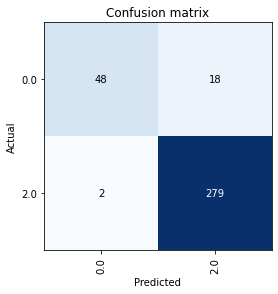

In [12]:
c_interp.plot_confusion_matrix()

In [9]:
c_interp.most_confused()

[(0.0, 2.0, 11), (2.0, 0.0, 3)]

And we can predict on new texts quite easily:

In [ ]:
#check for accuracy
file = open('test.txt')
#text = full_df.text_content[full_df.index[full_df['sample_id'] == ['d002035'][0]]
text = file.read()
for i in range(2):
    if i == 0:
        preds = learn.predict(text)
        print("first classifier:")
    else:
        preds = learn2.predict(text)
        print("revised classifier")
    if preds[0] == '2.0':
        is_resume = "Yes"
        prob = preds[2][1]
    else:
        is_resume = "No"
        prob = preds[2][0]
    
    print(f"Is this a resume?: {is_resume}")
    print(f"Probability that I'm correct: {prob}")
file.close()


### Using the data block API

In [7]:
texts = DataBlock(blocks=(TextBlock.from_df(text_cols='text_content'), CategoryBlock),
                 get_x=ColReader('text'),
                 get_y=ColReader('is_resume'),
                 splitter=TrainTestSplitter())

In [8]:
dls_2 = texts.dataloaders(df)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [9]:
learn2 = text_classifier_learner(dls_2, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

Training log (revised aug 1): 1 epoch, 1 epoch, save, unfreeze, 10 epochs, save

Training log (revised aug 22): 5 epoch?, save, unfreeze, 1 epoch, save, unfreeze, 1 epoch, save

In [10]:
learn2.load('resume_classifier_aug_22_revised')

In [17]:
learn2.unfreeze()

In [18]:
learn2.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.120486,0.115471,0.974138,38:51


epoch,train_loss,valid_loss,accuracy,time
0,0.107616,0.086133,0.971264,1:21:32


In [19]:
learn2.save('resume_classifier_aug_22_revised')

Path('models/resume_classifier_aug_22_revised.pth')

In [20]:
c_interp2 = ClassificationInterpretation.from_learner(learn2)

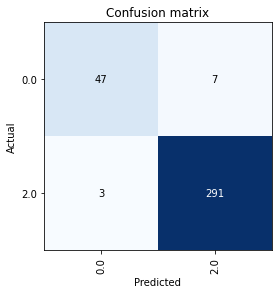

In [21]:
c_interp2.plot_confusion_matrix()

In [16]:
prompt = 'resume'
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)


AttributeError: 'SequentialRNN' object has no attribute 'generate'

## The ULMFiT approach

![ULMFit process](https://github.com/fastai/fastai/blob/master/nbs/images/ulmfit.png?raw=1)

### Fine-tuning a language model on IMDb

In [ ]:
dls_lm = TextDataLoaders.from_folder(path, is_lm=True, valid_pct=0.1)

We need to pass something for `valid_pct` otherwise this method will try to split the data by using the grandparent folder names. By passing `valid_pct=0.1`, we tell it to get a random 10% of those reviews for the validation set.

We can have a look at our data using `show_batch`. Here the task is to guess the next word, so we can see the targets have all shifted one word to the right.

In [ ]:
dls_lm.show_batch(max_n=5)

Then we have a convenience method to directly grab a `Learner` from it, using the `AWD_LSTM` architecture like before. We use accuracy and perplexity as metrics (the later is the exponential of the loss) and we set a default weight decay of 0.1. `to_fp16` puts the `Learner` in mixed precision, which is going to help speed up training on GPUs that have Tensor Cores.

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

By default, a pretrained `Learner` is in a frozen state, meaning that only the head of the model will train while the body stays frozen. We show you what is behind the fine_tune method here and use a fit_one_cycle method to fit the model:

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('1epoch')

In [ ]:
learn = learn.load('1epoch')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [ ]:
learn.save_encoder('finetuned')

In [14]:
TEXT = "I liked this movie by Robert Downey Jr. because"
N_WORDS = 30
N_SENTENCES = 1
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

TypeError: predict() got an unexpected keyword argument 'temperature'

In [ ]:
display(preds[0])

### Training a text classifier

We can gather our data for text classification almost exactly like before:

In [ ]:
dls_clas = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', text_vocab=dls_lm.vocab)

The main difference is that we have to use the exact same vocabulary as when we were fine-tuning our language model, or the weights learned won't make any sense. We pass that vocabulary with `text_vocab`.

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

The difference is that before training it, we load the previous encoder:

In [ ]:
learn = learn.load_encoder('finetuned')

The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

In [ ]:
learn.fit_one_cycle(1, 2e-2)

We can unfreeze the model little by little and then the whole model

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))